In [1]:
# set up main path where everything will be you should download the
# hugging face directory described in readme and put it here on the same
# server where the data analyzer is run so that the data analyzer code with 
# the GPU can access these files
# You should replace the below path with your location
import json
import os
try:
    with open('conf/config.json', 'r') as f:
        config = json.load(f)
    storage_path = config['storage_path']
    data_path = config['data_path']
    derivatives_path = config['derivatives_path']
    fsl_path = config['fsl_path']
    assert os.path.exists(storage_path), "The specified data and model storage path does not exist."
    assert os.path.exists(data_path), "The specified BOLD path does not exist."
    assert os.path.exists(derivatives_path), "The specified derivatives path does not exist."
    assert os.path.exists(fsl_path), "The specified FSL path does not exist."
except FileNotFoundError:
    raise FileNotFoundError("config.json file not found. Please create it with the required paths.")

print(f"Using storage path: {storage_path}")

"""-----------------------------------------------------------------------------
Imports and set up for mindEye
-----------------------------------------------------------------------------"""

import sys
import shutil
import argparse
import numpy as np
import math
import time
import random
import string
import h5py
from scipy import stats
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator, DeepSpeedPlugin
# SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
sys.path.append('generative_models/')
# print(sys.path)
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder, FrozenOpenCLIPEmbedder2
from generative_models.sgm.models.diffusion import DiffusionEngine
from generative_models.sgm.util import append_dims
from omegaconf import OmegaConf
from PIL import Image
# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True
# custom functions #
import utils_mindeye
from models import *
import pandas as pd
import ants
import nilearn
import pdb
from nilearn.plotting import plot_design_matrix
### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
accelerator = Accelerator(split_batches=False, mixed_precision="fp16")
device = accelerator.device

%load_ext autoreload
%autoreload 2

Using storage path: /home/ri4541@pu.win.princeton.edu/rt_mindeye/rt_all_data
line 6:  /home/ri4541@pu.win.princeton.edu/rtcloud-projects/mindeye
line 6:  /home/ri4541@pu.win.princeton.edu/rtcloud-projects/mindeye
line 14:  /home/ri4541@pu.win.princeton.edu/rtcloud-projects/mindeye
line 14:  /home/ri4541@pu.win.princeton.edu/rtcloud-projects/mindeye


In [2]:
cache_dir= f"{storage_path}/cache"
model_name="sub-005_all_task-C_bs24_MST_rishab_MSTsplit_union_mask_finetune_0"
subj=1
hidden_dim=1024
blurry_recon = False
n_blocks=4 
seq_len = 1

import pickle
with open(f"{storage_path}/clip_img_embedder", "rb") as input_file:
    clip_img_embedder = pickle.load(input_file)
clip_img_embedder.to(device)
clip_seq_dim = 256
clip_emb_dim = 1664

In [3]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x

model = MindEyeModule()

class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer
    def __init__(self, input_sizes, out_features, seq_len): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
                torch.nn.Linear(input_size, out_features) for input_size in input_sizes
            ])
    def forward(self, x, subj_idx):
        out = torch.cat([self.linears[subj_idx](x[:,seq]).unsqueeze(1) for seq in range(seq_len)], dim=1)
        return out
num_voxels = 8627
model.ridge = RidgeRegression([num_voxels], out_features=hidden_dim, seq_len=seq_len)

from diffusers.models.vae import Decoder
class BrainNetwork(nn.Module):
    def __init__(self, h=4096, in_dim=15724, out_dim=768, seq_len=2, n_blocks=n_blocks, drop=.15, 
                clip_size=768):
        super().__init__()
        self.seq_len = seq_len
        self.h = h
        self.clip_size = clip_size

        self.mixer_blocks1 = nn.ModuleList([
            self.mixer_block1(h, drop) for _ in range(n_blocks)
        ])
        self.mixer_blocks2 = nn.ModuleList([
            self.mixer_block2(seq_len, drop) for _ in range(n_blocks)
        ])

        # Output linear layer
        self.backbone_linear = nn.Linear(h * seq_len, out_dim, bias=True) 
        self.clip_proj = self.projector(clip_size, clip_size, h=clip_size)


    def projector(self, in_dim, out_dim, h=2048):
        return nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.GELU(),
            nn.Linear(in_dim, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, out_dim)
        )

    def mlp(self, in_dim, out_dim, drop):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(out_dim, out_dim),
        )

    def mixer_block1(self, h, drop):
        return nn.Sequential(
            nn.LayerNorm(h),
            self.mlp(h, h, drop),  # Token mixing
        )

    def mixer_block2(self, seq_len, drop):
        return nn.Sequential(
            nn.LayerNorm(seq_len),
            self.mlp(seq_len, seq_len, drop)  # Channel mixing
        )

    def forward(self, x):
        # make empty tensors
        c,b,t = torch.Tensor([0.]), torch.Tensor([[0.],[0.]]), torch.Tensor([0.])

        # Mixer blocks
        residual1 = x
        residual2 = x.permute(0,2,1)
        for block1, block2 in zip(self.mixer_blocks1,self.mixer_blocks2):
            x = block1(x) + residual1
            residual1 = x
            x = x.permute(0,2,1)

            x = block2(x) + residual2
            residual2 = x
            x = x.permute(0,2,1)

        x = x.reshape(x.size(0), -1)
        backbone = self.backbone_linear(x).reshape(len(x), -1, self.clip_size)
        c = self.clip_proj(backbone)

        return backbone, c, b

model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=seq_len, 
                        clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim) 
utils_mindeye.count_params(model.ridge)
utils_mindeye.count_params(model.backbone)
utils_mindeye.count_params(model)

# setup diffusion prior network
out_dim = clip_emb_dim
depth = 6
dim_head = 52
heads = clip_emb_dim//52 # heads * dim_head = clip_emb_dim
timesteps = 100

prior_network = PriorNetwork(
        dim=out_dim,
        depth=depth,
        dim_head=dim_head,
        heads=heads,
        causal=False,
        num_tokens = clip_seq_dim,
        learned_query_mode="pos_emb"
    )

model.diffusion_prior = BrainDiffusionPrior(
    net=prior_network,
    image_embed_dim=out_dim,
    condition_on_text_encodings=False,
    timesteps=timesteps,
    cond_drop_prob=0.2,
    image_embed_scale=None,
)
model.to(device)

utils_mindeye.count_params(model.diffusion_prior)
utils_mindeye.count_params(model)

param counts:
8,835,072 total
8,835,072 trainable
param counts:
453,360,280 total
453,360,280 trainable
param counts:
462,195,352 total
462,195,352 trainable
param counts:
259,865,216 total
259,865,200 trainable
param counts:
722,060,568 total
722,060,552 trainable


722060552

In [4]:
# Load pretrained model ckpt
# Replace with pre_trained_fine_tuned_model.pth
# tag='pretrained_fine-tuned_sliceTimed0.5.pth'
# tag='pretrained_fine-tuned_sliceTimed.pth'
tag='sub-005_all_task-C_bs24_MST_rishab_MSTsplit_union_mask_finetune_0.pth'
outdir = os.path.abspath(f'3t/data/model')

# print(f"\n---loading {outdir}/{tag}.pth ckpt---\n")
# try:
checkpoint = torch.load(outdir+f'/{tag}', map_location='cpu')
state_dict = checkpoint['model_state_dict']
model.load_state_dict(state_dict, strict=True)
del checkpoint
# except: # probably ckpt is saved using deepspeed format
#     import deepspeed
#     state_dict = deepspeed.utils.zero_to_fp32.get_fp32_state_dict_from_zero_checkpoint(checkpoint_dir=outdir, tag=tag)
#     model.load_state_dict(state_dict, strict=False)
#     del state_dict
# print("ckpt loaded!")


In [5]:
# prep unCLIP
config = OmegaConf.load("generative_models/configs/unclip6.yaml")
config = OmegaConf.to_container(config, resolve=True)
unclip_params = config["model"]["params"]
network_config = unclip_params["network_config"]
denoiser_config = unclip_params["denoiser_config"]
# first_stage_config = unclip_params["first_stage_config"]
conditioner_config = unclip_params["conditioner_config"]
sampler_config = unclip_params["sampler_config"]
scale_factor = unclip_params["scale_factor"]
disable_first_stage_autocast = unclip_params["disable_first_stage_autocast"]
offset_noise_level = unclip_params["loss_fn_config"]["params"]["offset_noise_level"]
# first_stage_config['target'] = 'sgm.models.autoencoder.AutoencoderKL'
sampler_config['params']['num_steps'] = 38
with open(f"{storage_path}/diffusion_engine", "rb") as input_file:
    diffusion_engine = pickle.load(input_file)
# set to inference
diffusion_engine.eval().requires_grad_(False)
diffusion_engine.to(device)
ckpt_path = f'{cache_dir}/unclip6_epoch0_step110000.ckpt'
ckpt = torch.load(ckpt_path, map_location='cpu')
diffusion_engine.load_state_dict(ckpt['state_dict'])
batch={"jpg": torch.randn(1,3,1,1).to(device), # jpg doesnt get used, it's just a placeholder
    "original_size_as_tuple": torch.ones(1, 2).to(device) * 768,
    "crop_coords_top_left": torch.zeros(1, 2).to(device)}
out = diffusion_engine.conditioner(batch)
vector_suffix = out["vector"].to(device)
# f = h5py.File(f'{storage_path}/coco_images_224_float16.hdf5', 'r')
# images = f['images']

In [6]:

sub = "sub-005"
session = "ses-03"
task = 'C'  # 'study' or 'A'; used to search for functional run in bids format
func_task_name = 'C'  # 'study' or 'A'; used to search for functional run in bids format
n_runs = 11

ses_list = [session]
design_ses_list = [session]
    
task_name = f"_task-{task}" if task != 'study' else ''
designdir = f"{data_path}/events"

In [7]:
data, starts, images, is_new_run, image_names, unique_images, len_unique_images = utils_mindeye.load_design_files(
    sub=sub,
    session=session,
    func_task_name=task,
    designdir=designdir,
    design_ses_list=design_ses_list
)

if sub == 'sub-001':
    if session == 'ses-01':
        assert image_names[0] == 'images/image_686_seed_1.png'
    elif session in ('ses-02', 'all'):
        assert image_names[0] == 'all_stimuli/special515/special_40840.jpg'
    elif session == 'ses-03':
        assert image_names[0] == 'all_stimuli/special515/special_69839.jpg'
    elif session == 'ses-04':
        assert image_names[0] == 'all_stimuli/rtmindeye_stimuli/image_686_seed_1.png'
elif sub == 'sub-003':
    assert image_names[0] == 'all_stimuli/rtmindeye_stimuli/image_686_seed_1.png'

unique_images = np.unique(image_names.astype(str))
unique_images = unique_images[(unique_images!="nan")]
len_unique_images = len(unique_images)
print("n_runs",n_runs)

if (sub == 'sub-001' and session == 'ses-04') or (sub == 'sub-003' and session == 'ses-01'):
    assert len(unique_images) == 851

print(image_names[:4])
print(starts[:4])
print(is_new_run[:4])

image_idx = np.array([])  # contains the unique index of each presented image
vox_image_names = np.array([])  # contains the names of the images corresponding to image_idx
all_MST_images = dict()
for i, im in enumerate(image_names):
    # skip if blank, nan
    if im == "blank.jpg":
        i+=1
        continue
    if str(im) == "nan":
        i+=1
        continue
    vox_image_names = np.append(vox_image_names, im)
            
    image_idx_ = np.where(im==unique_images)[0].item()
    image_idx = np.append(image_idx, image_idx_)
    
    all_MST_images[i] = im
    i+=1
    
image_idx = torch.Tensor(image_idx).long()
# for im in new_image_names[MST_images]:
#     assert 'MST_pairs' in im
# assert len(all_MST_images) == 300

unique_MST_images = np.unique(list(all_MST_images.values())) 

MST_ID = np.array([], dtype=int)

vox_idx = np.array([], dtype=int)
j=0  # this is a counter keeping track of the remove_random_n used later to index vox based on the removed images; unused otherwise
for i, im in enumerate(image_names):  # need unique_MST_images to be defined, so repeating the same loop structure
    # skip if blank, nan
    if im == "blank.jpg":
        i+=1
        continue
    if str(im) == "nan":
        i+=1
        continue
    j+=1
    curr = np.where(im == unique_MST_images)
    # print(curr)
    if curr[0].size == 0:
        MST_ID = np.append(MST_ID, np.array(len(unique_MST_images)))  # add a value that should be out of range based on the for loop, will index it out later
    else:
        MST_ID = np.append(MST_ID, curr)
        
assert len(MST_ID) == len(image_idx)
# assert len(np.argwhere(pd.isna(data['current_image']))) + len(np.argwhere(data['current_image'] == 'blank.jpg')) + len(image_idx) == len(data)
# MST_ID = torch.tensor(MST_ID[MST_ID != len(unique_MST_images)], dtype=torch.uint8)  # torch.tensor (lowercase) allows dtype kwarg, Tensor (uppercase) is an alias for torch.FloatTensor
print(MST_ID.shape)
if (sub == 'sub-001' and session == 'ses-04') or (sub == 'sub-003' and session == 'ses-01'):
    assert len(all_MST_images) == 100

Data shape: (780, 126)
Using design file: /home/ri4541@pu.win.princeton.edu/rtcloud-projects/mindeye/3t/data/events/csv/sub-005_ses-03.csv
Total number of images: 770
Number of unique images: 532
n_runs 11
['all_stimuli/unchosen_nsd_1000_images/unchosen_7211_cocoid_59250.png'
 'all_stimuli/special515/special_67295.jpg'
 'all_stimuli/unchosen_nsd_1000_images/unchosen_5729_cocoid_53029.png'
 'all_stimuli/special515/special_70232.jpg']
[174.7109683 178.7049172 182.7072832 186.7297016]
[0. 0. 0. 0.]
(693,)


In [8]:
import imageio.v2 as imageio
resize_transform = transforms.Resize((224, 224))
MST_images = []
images = None
for im_name in tqdm(image_idx):
    image_file = f"{unique_images[im_name]}"
    im = imageio.imread(f"{data_path}/{image_file}")
    im = torch.Tensor(im / 255).permute(2,0,1)
    im = resize_transform(im.unsqueeze(0))
    if images is None:
        images = im
    else:
        images = torch.vstack((images, im))
    if ("MST_pairs" in image_file): # ("_seed_" not in unique_images[im_name]) and (unique_images[im_name] != "blank.jpg") 
        MST_images.append(True)
    else:
        MST_images.append(False)

print("images", images.shape)
MST_images = np.array(MST_images)
print("len MST_images", len(MST_images))
assert len(MST_images[MST_images==True]) == 124
print("MST_images==True", len(MST_images[MST_images==True]))


  0%|                                                                                                                                      | 0/693 [00:00<?, ?it/s]/home/ri4541@pu.win.princeton.edu/miniforge3/envs/rt_mindEye2/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████

images torch.Size([693, 3, 224, 224])
len MST_images 693
MST_images==True 124


In [9]:
def get_image_pairs(sub, session, func_task_name, designdir):
    """Loads design files and processes image pairs for a given session."""
    _, _, _, _, image_names, unique_images, _ = utils_mindeye.load_design_files(
        sub=sub,
        session=session,
        func_task_name=func_task_name,
        designdir=designdir,
        design_ses_list=[session]  # Ensure it's a list
    )
    return utils_mindeye.process_images(image_names, unique_images)

In [10]:
from collections import defaultdict

all_dicts = []
for s_idx, s in enumerate(ses_list):
    im, vo, _ = get_image_pairs(sub, s, func_task_name, designdir)
    assert len(im) == len(vo)
    all_dicts.append({k:v for k,v in enumerate(vo)})

assert session == 'ses-03'
image_to_indices = defaultdict(lambda: [[] for _ in range(len(ses_list))])
for ses_idx, idx_to_name in enumerate(all_dicts):
    for idx, name in idx_to_name.items():
        image_to_indices[name][ses_idx].append(idx)
        
image_to_indices = dict(image_to_indices)

Data shape: (780, 126)
Using design file: /home/ri4541@pu.win.princeton.edu/rtcloud-projects/mindeye/3t/data/events/csv/sub-005_ses-03.csv
Total number of images: 770
Number of unique images: 532


In [11]:
utils_mindeye.seed_everything(0)
MST_idx = np.array([v for k,v in image_to_indices.items() if 'MST_pairs' in k])
# train_image_indices = np.array([]).astype(np.int8)
# test_image_indices = np.concatenate([np.where(MST_images == True)[0], np.where(MST_images == False)[0]])
train_image_indices = np.where(MST_images == False)[0]
test_image_indices = np.where(MST_images == True)[0]
print(len(train_image_indices), len(test_image_indices))

# for now, use the first subset of repeats only
MST_idx = MST_idx[:,0,0]
print("MST_idx", MST_idx.shape)

569 124
MST_idx (62,)


In [12]:
import pandas as pd
import nibabel as nib
from nilearn.glm.first_level import FirstLevelModel
from nilearn.image import get_data, index_img, concat_imgs, new_img_like

# bold = nib.load(f"{data_path}/sub-005_ses-03_task-C_run-01_bold.nii.gz")  # shouldn't load all the data 

# get the mask and the reference files
ndscore_events = [pd.read_csv(f'{data_path}/events/sub-005_ses-03_task-C_run-{run+1:02d}_events.tsv', sep = "\t", header = 0) for run in range(n_runs)]  # create a new list of events_df's which will have the trial_type modified to be unique identifiers
ndscore_tr_labels = [pd.read_csv(f"{data_path}/events/sub-005_ses-03_task-C_run-{run+1:02d}_tr_labels.csv") for run in range(n_runs)]
tr_length = 1.5
mask_img = nib.load(f'{data_path}/sub-005_final_mask.nii.gz')  # nsdgeneral mask in functional space
ses1_boldref= f"{data_path}/sub-005_ses-01_task-C_run-01_space-T1w_boldref.nii.gz"  # preprocessed boldref from ses-01
# ses3_vol0= f"{data_path}/../derivatives/vols/sub-005_ses-03_task-C_run-01_bold_0000.nii.gz" # first volume (vol0000) of real-time session
# day2_to_day1_mat =  f"{storage_path}/day2ref_to_day1ref"
def fast_apply_mask(target=None,mask=None):
    return target[np.where(mask == 1)].T
ses1_boldref_nib = nib.load(ses1_boldref)
union_mask = np.load(f"{data_path}/union_mask_from_ses-01-02.npy")

In [13]:
# apply union mask to the nsdgeneral ROI and convert to nifti
assert mask_img.get_fdata().sum() == union_mask.shape
union_mask_img = new_img_like(mask_img, union_mask)

In [14]:
# apply union_mask to mask_img and return nifti object

# Get the data as a boolean array
mask_data = mask_img.get_fdata().astype(bool)

# Flatten only the True voxels in the mask
true_voxel_indices = np.where(mask_data.ravel())[0]

# Apply the union_mask (boolean mask of size 19174)
selected_voxel_indices = true_voxel_indices[union_mask]

# Create a new flattened mask with all False
new_mask_flat = np.zeros(mask_data.size, dtype=bool)

# Set selected voxels to True
new_mask_flat[selected_voxel_indices] = True

# Reshape back to original 3D shape
new_mask_data = new_mask_flat.reshape(mask_data.shape)

# Create new NIfTI image
union_mask_img = nib.Nifti1Image(new_mask_data.astype(np.uint8), affine=mask_img.affine)

In [15]:
print("union_mask_img.shape", union_mask_img.shape)
print("union mask num voxels", int(union_mask_img.get_fdata().sum()))

union_mask_img.shape (76, 90, 74)
union mask num voxels 8627


In [16]:
def do_reconstructions(betas_tt):
    """
    takes in the beta map for a stimulus trial in torch tensor format (tt)

    returns reconstructions and clipvoxels for retrievals
    """
    # start_reconstruction_time = time.time()
    model.to(device)
    model.eval().requires_grad_(False)
    clipvoxelsTR = None
    reconsTR = None
    num_samples_per_image = 1
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
        voxel = betas_tt
        voxel = voxel.to(device)
        voxel_ridge = model.ridge(voxel[:,[0]],0) # 0th index of subj_list
        backbone0, clip_voxels0, blurry_image_enc0 = model.backbone(voxel_ridge)
        clip_voxels = clip_voxels0
        backbone = backbone0
        blurry_image_enc = blurry_image_enc0[0]
        clipvoxelsTR = clip_voxels.cpu()
        prior_out = model.diffusion_prior.p_sample_loop(backbone.shape, 
                        text_cond = dict(text_embed = backbone), 
                        cond_scale = 1., timesteps = 20)  
        for i in range(len(voxel)):
            samples = utils_mindeye.unclip_recon(prior_out[[i]],
                            diffusion_engine,
                            vector_suffix,
                            num_samples=num_samples_per_image)
            if reconsTR is None:
                reconsTR = samples.cpu()
            else:
                reconsTR = torch.vstack((reconsTR, samples.cpu()))
            imsize = 224
            reconsTR = transforms.Resize((imsize,imsize), antialias=True)(reconsTR).float().numpy().tolist()
        return reconsTR, clipvoxelsTR
    
def batchwise_cosine_similarity(Z,B):
    Z = Z.flatten(1)
    B = B.flatten(1).T
    Z_norm = torch.linalg.norm(Z, dim=1, keepdim=True)  # Size (n, 1).
    B_norm = torch.linalg.norm(B, dim=0, keepdim=True)  # Size (1, b).
    cosine_similarity = ((Z @ B) / (Z_norm @ B_norm)).T
    return cosine_similarity

def get_top_retrievals(clipvoxel, all_images, total_retrievals = 1):
    '''
    clipvoxel: output from do_recons that contains that information needed for retrievals
    all_images: all ground truth actually seen images by the participant in day 2 run 1

    outputs the top retrievals
    '''
    values_dict = {}
    with torch.cuda.amp.autocast(dtype=torch.float16):
        emb = clip_img_embedder(torch.reshape(all_images,(all_images.shape[0], 3, 224, 224)).to(device)).float() # CLIP-Image
        emb = emb.cpu()
        emb_ = clipvoxel # CLIP-Brain
        emb = emb.reshape(len(emb),-1)
        emb_ = np.reshape(emb_, (1, 425984))
        emb = nn.functional.normalize(emb,dim=-1)
        emb_ = nn.functional.normalize(emb_,dim=-1)
        emb_ = emb_.float()
        fwd_sim = batchwise_cosine_similarity(emb_,emb)  # brain, clip
        print("Given Brain embedding, find correct Image embedding")
    fwd_sim = np.array(fwd_sim.cpu())
    which = np.flip(np.argsort(fwd_sim, axis = 0))
    imsize = 224
    for attempt in range(total_retrievals):
        values_dict[f"attempt{(attempt+1)}"] = transforms.Resize((imsize,imsize), antialias=True)(all_images[which[attempt].copy()]).float().numpy().tolist()
    return values_dict


def convert_image_array_to_PIL(image_array):
    if image_array.ndim == 4:
        image_array = image_array[0]

    # get the dimension to h, w, 3|1
    if image_array.ndim == 3 and image_array.shape[0] == 3:
        image_array = np.transpose(image_array, (1, 2, 0))  # Change shape to (height, width, 3)
    
    # clip the image array to 0-1
    image_array = np.clip(image_array, 0, 1)
    # convert the image array to uint8
    image_array = (image_array * 255).astype('uint8')
    # convert the image array to PIL
    return Image.fromarray(image_array)


In [17]:
# load fmriprepped data
fmriprep_data_path = '/home/ri4541@pu.win.princeton.edu/rtcloud-projects/mindeye/3t/data/testing'
fmriprep_data = []

for run in range(n_runs):
    tmp = nib.load(f'{fmriprep_data_path}/sub-005_ses-03_task-C_run-{run+1:02d}_space-T1w_desc-preproc_bold.nii.gz')
    fmriprep_data.append(tmp)

fmriprep_data = np.array(fmriprep_data)
print(fmriprep_data.shape)

(11,)


In [18]:
mc_dir = '/home/ri4541@pu.win.princeton.edu/rtcloud-projects/mindeye/3t/derivatives/motion_corrected_resampled'

mc_vols = np.zeros(shape=(n_runs, 191, 76, 90, 74))
for i in range(n_runs):
    for tr in range(191):
        tmp = nib.load(os.path.join(mc_dir, f'ses-03_run-{i+1:02d}_{tr:04d}_mc_boldres.nii.gz'))
        tmp = tmp.get_fdata()
        assert tmp.shape == (76, 90, 74)
        mc_vols[i, tr] = tmp

mc_data = [nib.Nifti1Image(mc_vols[i].transpose(1,2,3,0), affine=union_mask_img.affine) for i in range(n_runs)]
mc_data[0].shape

KeyboardInterrupt: 

In [19]:
plot_images=True
save_individual_images=True

#### real-time compatible preprocessing, fit GLM with data up to each TR only 

In [ ]:
# run nilearn firstlevel glm
from nilearn.glm.first_level import FirstLevelModel

all_betas = []
for run in range(1, n_runs+1):
    save_path = f"{derivatives_path}/sub-005_ses-03_task-C_run-{run:02d}_recons_data-fmriprep-all_delay-8"
    os.makedirs(save_path, exist_ok=True)
    save_individual_images = True
    if save_individual_images:
        os.makedirs(os.path.join(save_path, "individual_images"), exist_ok=True)

    all_recons_save = []
    all_clipvoxels_save = []
    all_ground_truth_save = []
    all_retrieved_save = []


    print(f"Run {run} started")
    events_df = ndscore_events[run-1]
    tr_labels_hrf = ndscore_tr_labels[run-1]["tr_label_hrf"].tolist()
    events_df = events_df[events_df['image_name'] != 'blank.jpg']  # must drop blank.jpg after tr_labels_hrf is defined to keep indexing consistent

    for TR in range(192):
        stimulus_trial_counter = np.sum(
            [label != 'blank' for label in tr_labels_hrf[:TR]]
        )  # stimulus_trial_counter is the trial number minus blank trials; this indexes cropped_events which does not contain blank.jpg since we don't model blank trials
        print(f"TR {TR}")
        current_label = tr_labels_hrf[TR]
        print(current_label)
        
        if current_label not in ('blank', 'blank.jpg'):
            events_df = events_df.copy()
            events_df['onset'] = events_df['onset'].astype(float)

            run_start_time = events_df['onset'].iloc[0]
            events_df = events_df.copy()
            events_df['onset'] -= run_start_time

            cropped_events = events_df[events_df.onset <= TR*tr_length]
            cropped_events = cropped_events.copy()
            print(stimulus_trial_counter)
            print(np.where(cropped_events['trial_number'] == stimulus_trial_counter))
            assert cropped_events['trial_number'].eq(stimulus_trial_counter).any(), "No matching trial_number found in cropped_events"
            cropped_events.loc[:, 'trial_type'] = np.where(cropped_events['trial_number'] == stimulus_trial_counter, "probe", "reference")
            cropped_events = cropped_events.drop(columns=['is_correct', 'image_name', 'response_time', 'trial_number'])

            lss_glm = FirstLevelModel(t_r=tr_length,slice_time_ref=0,hrf_model='glover',
                        drift_model='cosine', drift_order=1,high_pass=0.01,mask_img=union_mask_img,
                        signal_scaling=False,smoothing_fwhm=None,noise_model='ar1',
                        n_jobs=-1,verbose=-1,memory_level=1,minimize_memory=True)

            # lss_glm.fit(run_imgs=mc_data[run-1].slicer[:,:,:,:TR], events=cropped_events)
            # lss_glm.fit(run_imgs=mc_data[run-1], events=cropped_events)
            # lss_glm.fit(run_imgs=fmriprep_data[run-1].slicer[:,:,:,:TR], events=cropped_events)
            lss_glm.fit(run_imgs=fmriprep_data[run-1], events=cropped_events)

            dm = lss_glm.design_matrices_[0]
            beta_map = lss_glm.compute_contrast("probe", output_type="effect_size")
            beta_map_np = beta_map.get_fdata()
            beta_map_np = fast_apply_mask(target=beta_map_np,mask=union_mask_img.get_fdata())[0]
            all_betas.append(beta_map_np)

            if "MST_pairs" in current_label:
                correct_image_index = np.where(current_label == vox_image_names)[0][0]  # using the first occurrence based on image name, assumes that repeated images are identical (which they should be)
                z_mean = np.mean(np.array(all_betas), axis=0)
                z_std = np.std(np.array(all_betas), axis=0)
                betas = ((np.array(all_betas) - z_mean) / (z_std + 1e-6))[-1]  # use only the beta pattern from the most recent image
                # betas = np.array(all_betas)
                # pdb.set_trace()
                betas = betas[np.newaxis, np.newaxis, :]
                betas_tt = torch.Tensor(betas).to("cpu")
                reconsTR, clipvoxelsTR = do_reconstructions(betas_tt)
                if clipvoxelsTR is None:
                    with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
                        voxel = betas_tt
                        voxel = voxel.to(device)
                        assert voxel.shape[1] == 1
                        voxel_ridge = model.ridge(voxel[:,[-1]],0) # 0th index of subj_list
                        backbone0, clip_voxels0, blurry_image_enc0 = model.backbone(voxel_ridge)
                        clip_voxels = clip_voxels0
                        backbone = backbone0
                        blurry_image_enc = blurry_image_enc0[0]
                        clipvoxelsTR = clip_voxels.cpu()
                values_dict = get_top_retrievals(clipvoxelsTR, all_images=images[MST_idx], total_retrievals=5)
                image_array = np.array(reconsTR)[0]
                # If the image has 3 channels (RGB), you need to reorder the dimensions
                if image_array.ndim == 3 and image_array.shape[0] == 3:
                    image_array = np.transpose(image_array, (1, 2, 0))  # Change shape to (height, width, 3)

                # Display the image
                if plot_images:
                    # plot original and reconstructed images
                    plt.figure(figsize=(10, 5))
                    plt.subplot(1, 2, 1)
                    plt.title("Original Image")
                    plt.imshow(images[correct_image_index].numpy().transpose(1, 2, 0), cmap='gray')
                    plt.axis('off')
                    plt.subplot(1, 2, 2)
                    plt.title("Reconstructed Image")
                    plt.imshow(image_array, cmap='gray' if image_array.ndim == 2 else None)
                    plt.axis('off')
                    plt.show()

                    # plot original with top 5 retrievals
                    plt.figure(figsize=(10, 5))
                    plt.subplot(1, 6, 1)
                    plt.title("Original Image")
                    plt.imshow(images[correct_image_index].numpy().transpose(1, 2, 0), cmap='gray')
                    plt.axis('off')
                    for i in range(5):
                        plt.subplot(1, 6, i+2)
                        plt.title(f"Retrieval {i+1}")
                        plt.imshow(np.array(values_dict[f"attempt{i+1}"][0]).transpose(1, 2, 0), cmap='gray')
                        plt.axis('off')
                    plt.show()

                    if save_individual_images:
                    # save the reconstructed image
                        convert_image_array_to_PIL(image_array).save(os.path.join(save_path, "individual_images", f"run{run}_TR{TR}_reconstructed.png"))
                        # save the retrieved images
                        for key, value in values_dict.items():
                            if (not ('ground_truth' in key)):
                                convert_image_array_to_PIL(np.array(value)).save(os.path.join(save_path, "individual_images", f"run{run}_TR{TR}_retrieved_{key}.png"))
                        # save the clip_voxels
                        np.save(os.path.join(save_path, "individual_images", f"run{run}_TR{TR}_clip_voxels.npy"), clipvoxelsTR)
                        # save the ground truth image
                        convert_image_array_to_PIL(images[correct_image_index].numpy()).save(os.path.join(save_path, "individual_images", f"run{run}_TR{TR}_ground_truth.png"))
                        all_recons_save.append(image_array)
                        all_clipvoxels_save.append(clipvoxelsTR)
                        all_ground_truth_save.append(images[correct_image_index].numpy())
                        all_retrieved_save.append([np.array(value) for key, value in values_dict.items() if (not ('ground_truth' in key))])

                    elif current_label == 'blank.jpg':
                        pass
                    else:
                        assert current_label == 'blank'

    # save the design matrix for the current run
    dm.to_csv(os.path.join(save_path, f"design_run-{run:02d}.csv"))
    plot_design_matrix(dm, output_file=os.path.join(save_path, "dm"))
    dm[['probe', 'reference']].plot(title='Probe/Reference Regressors', figsize=(10, 4))
    plt.savefig(os.path.join(save_path, "regressors"))
    # save betas so far
    np.save(os.path.join(save_path, f"betas_run-{run:02d}.npy"), np.array(all_betas))
    print(f"==END OF RUN {run}!==\n")
    # save the tensors
    if all_recons_save:
        all_recons_save_tensor = torch.tensor(all_recons_save).permute(0,3,1,2)
        all_clipvoxels_save_tensor = torch.stack(all_clipvoxels_save, dim=0)
        all_ground_truth_save_tensor = torch.tensor(all_ground_truth_save)
        all_retrieved_save_tensor = torch.stack([torch.tensor(np.array(item)) for item in all_retrieved_save], dim=0)
        torch.save(all_recons_save_tensor, os.path.join(save_path, "all_recons.pt"))
        torch.save(all_clipvoxels_save_tensor, os.path.join(save_path, "all_clipvoxels.pt"))
        torch.save(all_ground_truth_save_tensor, os.path.join(save_path, "all_ground_truth.pt"))
        torch.save(all_retrieved_save_tensor, os.path.join(save_path, "all_retrieved.pt"))
        print("all_recons_save_tensor.shape: ", all_recons_save_tensor.shape)
        print("all_clipvoxels_save_tensor.shape: ", all_clipvoxels_save_tensor.shape)
        print("all_ground_truth_save_tensor.shape: ", all_ground_truth_save_tensor.shape)
        print("all_retrieved_save_tensor.shape: ", all_retrieved_save_tensor.shape)
        print("All tensors saved successfully on ", save_path)

In [ ]:
# np.save(f"{derivatives_path}/debugging/betas_run-01-11_data-fmriprep-all_delay-8.npy", np.array(all_betas))

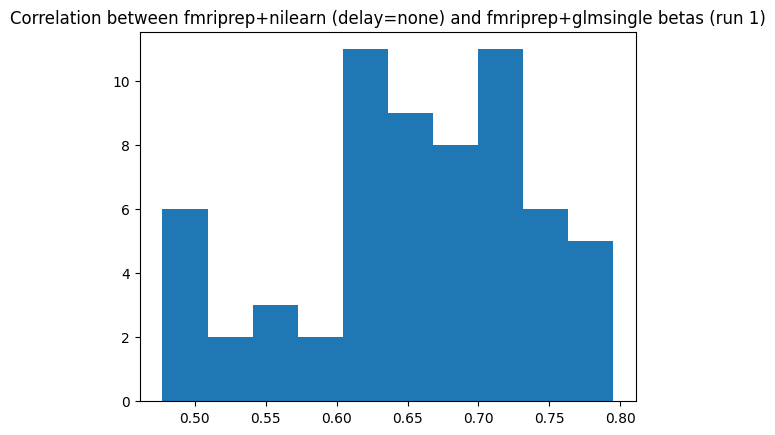

In [ ]:
b1 = np.load('/home/ri4541@pu.win.princeton.edu/rtcloud-projects/mindeye/3t/derivatives/debugging/betas_run-01-11_data-fmriprep-all_delay-8.npy')
b2 = np.array(all_betas)
betas_path = f'{data_path}/testing/sub-005_ses-03_task-C_bs24_MST_rishab_MSTsplit_union_mask_0_vox.npy'
offline_betas_norm = np.load(betas_path)

# corrs, p = utils_mindeye.vectorized_pearsonr(b2[:63], offline_betas_norm[:63])
corrs, p = utils_mindeye.vectorized_pearsonr(b1, offline_betas_norm)
plt.hist(corrs)
plt.title('Correlation between fmriprep+nilearn (delay=none) and fmriprep+glmsingle betas (11 runs)')
plt.show()

In [ ]:
mc_dir = f"{derivatives_path}/motion_corrected"
mc_resampled_dir = f"{derivatives_path}/motion_corrected_resampled"
if os.path.exists(mc_dir):
    shutil.rmtree(mc_dir)
os.makedirs(mc_dir)
if os.path.exists(mc_resampled_dir):
    shutil.rmtree(mc_resampled_dir)
os.makedirs(mc_resampled_dir)

# set the output type to NIFTI_GZ
os.environ['FSLOUTPUTTYPE'] = 'NIFTI_GZ'
assert np.all(ses1_boldref_nib.affine == union_mask_img.affine)
all_betas = []

# Loop over all 11 runs in the session
n_runs = 11
for run_num in range(1, n_runs + 1):
    print(f"Run {run_num} started")
    mc_params = []
    imgs = []
    events_df = ndscore_events[run_num - 1]
    tr_labels_hrf = ndscore_tr_labels[run_num - 1]["tr_label_hrf"].tolist()
    events_df = events_df[events_df['image_name'] != 'blank.jpg']  # must drop blank.jpg after tr_labels_hrf is defined to keep indexing consistent
    beta_maps_list = []
    all_trial_names_list = []
    all_images = None
    
    # seen_label_before = ["blank"]
    # get the list of all images in torch tensor format for this run (should be 62 or 63 images)
    # all_COCO_ids = []
    # for TR in range(192):
    #     if tr_labels_hrf[TR] not in seen_label_before:
    #         seen_label_before.append(tr_labels_hrf[TR])
    #         image_id = np.where(tr_labels_hrf[TR] == vox_image_names)[0]
    #         if len(image_id) > 0:
    #             # check images are identical
    #             for i in range(len(image_id)):    
    #                 assert torch.all(images[i] == images[image_id[i]])
    #         new_image_pt = images[image_id[0][0]]
    #         all_images = new_image_pt if all_images == None else torch.vstack((all_images, new_image_pt))
    #         all_COCO_ids.append(image_id)
    # print(all_COCO_ids)


    # define save_path
    save_path = f"{derivatives_path}/sub-005_ses-03_task-C_run-{run_num:02d}_recons"
    os.makedirs(save_path, exist_ok=True)
    save_individual_images = True
    if save_individual_images:
        os.makedirs(os.path.join(save_path, "individual_images"), exist_ok=True)

    all_recons_save = []
    all_clipvoxels_save = []
    all_ground_truth_save = []
    all_retrieved_save = []

    stimulus_trial_counter = 0
    plot_images = True
    T1_brain = f"{data_path}/sub-005_desc-preproc_T1w_brain.nii.gz"
    n_trs = 192
    assert len(tr_labels_hrf) == n_trs, "there should be image labels for each TR"
    assert all(label in image_names for label in tr_labels_hrf if label != 'blank'), "Some labels in tr_labels_hrf are missing from image_names."
    assert len(images) > n_trs, "images array is too short."
    for TR in range(n_trs-1):
        print(f"TR {TR}")
        # stream in the nifti
        cur_vol = f"sub-005_ses-03_task-C_run-{run_num:02d}_bold_{TR:04d}"
        image_data = nib.load(f"{derivatives_path}/vols/{cur_vol}.nii.gz")
        current_label = tr_labels_hrf[TR]
        print(current_label)
        if TR == 0 and run_num == 1:
            ses3_vol0 = image_data
            # make the day 2 bold ref
            # nib.save(image_data, day2_boldref)
            # save the transformation from the day 2 bold ref to the day 1 
            # os.system(f"antsRegistrationSyNQuick.sh \
            #   -d 3 \
            #   -f {T1_brain} \
            #   -m {ses3_vol0} \
            #   -o {derivatives_path}/ses3_vol0_epi2T1_")

            # for simulation, just load it in
            ses3_boldref_path = f"{derivatives_path}/ses3_vol0_epi2T1_Warped.nii.gz"
            ses3_boldref = nib.load(ses3_boldref_path)
        # load nifti file
        # tmp = f'{storage_path}/day2_subj1/tmp_run{run_num}.nii.gz'
        # nib.save(index_img(image_data,0),tmp)
        start = time.time()
        mc = f"{mc_dir}/{cur_vol}_mc"
        os.system(f"{fsl_path}/mcflirt -in {derivatives_path}/vols/{cur_vol}.nii.gz -reffile {derivatives_path}/vols/sub-005_ses-03_task-C_run-01_bold_0000.nii.gz -out {mc} -plots -mats")
        mc_params.append(np.loadtxt(f'{mc}.par'))

        final_vol = f"{mc_resampled_dir}/ses-03_run-{run_num:02d}_{TR:04d}_mc_boldres.nii.gz"
        # use ants apply_transforms to chain transformations from current volume to boldref and boldref to T1
        warped_img = ants.apply_transforms(
            fixed=ants.image_read(ses1_boldref),
            moving=ants.image_read(f"{mc}.nii.gz"),
            transformlist=[
                f"{derivatives_path}/ses3_vol0_epi2T1_0GenericAffine.mat",
                f"{derivatives_path}/ses3_vol0_epi2T1_1Warp.nii.gz"
            ],
            interpolator='linear'  # or 'nearestNeighbor', 'bspline', etc.
        )
        ants.image_write(warped_img, final_vol)
        imgs.append(warped_img.get_fdata()) # only add to imgs list
        os.system(f"rm -r {mc}.mat")
        
        # if tr_labels_hrf[TR] != tr_labels_hrf[TR + 1] and tr_labels_hrf[TR] != "blank":
        #     print('last TR of real image')
        #     cropped_events = events_df[events_df.trial_number <= int(float(tr_labels_hrf[TR].split("_")[3]))].astype(str)
        #     for i_trial, trial in cropped_events.iterrows():
        #         cropped_events.loc[i_trial, "trial_type"] = "reference" if i_trial < (len(cropped_events) - 1) else "probe"
                
        #     # cropped_events = cropped_events.drop(columns=['total_novel_presses', 'change_mind', 'is_correct', 'time', 
        #     #                                     'response_time', 'response', '73k_id', 'trial_number', 
        #     #                                     '10k_id', 'memory_first', 'is_old_session', 'is_correct_session', 
        #     #                                     'missing_data', 'total_old_presses', 'memory_recent'])  # nilearn glm fit requires onset and duration; trial_type is optional (https://nilearn.github.io/stable/modules/generated/nilearn.glm.first_level.make_first_level_design_matrix.html#nilearn.glm.first_level.make_first_level_design_matrix)

        #     # get the image id from this stimulus trial that we are fitting a model on
        #     image_COCO_id = int(float(tr_labels_hrf[TR].split("_")[1])) - 1
        if current_label not in ('blank', 'blank.jpg'):
            events_df = events_df.copy()
            events_df['onset'] = events_df['onset'].astype(float)

            run_start_time = events_df['onset'].iloc[0]
            events_df = events_df.copy()
            events_df['onset'] -= run_start_time

            cropped_events = events_df[events_df.onset <= TR*tr_length]
            cropped_events = cropped_events.copy()
            cropped_events.loc[:, 'trial_type'] = np.where(cropped_events['trial_number'] == stimulus_trial_counter, "probe", "reference")
            cropped_events = cropped_events.drop(columns=['is_correct', 'image_name', 'response_time', 'trial_number'])

            # collect all of the images at each TR into a 4D time series
            img = np.rollaxis(np.array(imgs),0,4)
            img = new_img_like(ses1_boldref_nib,img,copy_header=True)
            # run the model with mc_params confounds to motion correct
            lss_glm = FirstLevelModel(t_r=tr_length,slice_time_ref=0,hrf_model='glover',
                        drift_model='cosine', drift_order=1,high_pass=0.01,mask_img=union_mask_img,
                        signal_scaling=False,smoothing_fwhm=None,noise_model='ar1',
                        n_jobs=-1,verbose=-1,memory_level=1,minimize_memory=True)
            
            lss_glm.fit(run_imgs=img, events=cropped_events, confounds = pd.DataFrame(np.array(mc_params)))
            dm = lss_glm.design_matrices_[0]
            # get the beta map and mask it
            beta_map = lss_glm.compute_contrast("probe", output_type="effect_size")
            beta_map_np = beta_map.get_fdata()
            beta_map_np = fast_apply_mask(target=beta_map_np,mask=union_mask_img.get_fdata())[0]
            # beta_map_np = np.reshape(beta_map_np, (1,1,19174))
            # pdb.set_trace()
            # beta_map_np = beta_map_np[0,0,union_mask]
            all_betas.append(beta_map_np)
            if "MST_pairs" in current_label:
                correct_image_index = np.where(current_label == vox_image_names)[0][0]  # using the first occurrence based on image name, assumes that repeated images are identical (which they should be)
                # z-score the beta map
                # if run_num == 1:
                #     # use avg of ses-01 and 02 (ses-01: -0.11676685 ± 1.0246168; ses-02: -0.02013384 ± 0.98079187)
                #     z_mean = -0.0684
                #     z_std = 1.0027
                # else:
                z_mean = np.mean(np.array(all_betas), axis=0)
                z_std = np.std(np.array(all_betas), axis=0)
                betas = ((np.array(all_betas) - z_mean) / (z_std + 1e-6))[-1]  # use only the beta pattern from the most recent image
                # betas = np.array(all_betas)
                # pdb.set_trace()
                betas = betas[np.newaxis, np.newaxis, :]
                betas_tt = torch.Tensor(betas).to("cpu")
                reconsTR, clipvoxelsTR = do_reconstructions(betas_tt)
                if clipvoxelsTR is None:
                    with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
                        voxel = betas_tt
                        voxel = voxel.to(device)
                        assert voxel.shape[1] == 1
                        voxel_ridge = model.ridge(voxel[:,[-1]],0) # 0th index of subj_list
                        backbone0, clip_voxels0, blurry_image_enc0 = model.backbone(voxel_ridge)
                        clip_voxels = clip_voxels0
                        backbone = backbone0
                        blurry_image_enc = blurry_image_enc0[0]
                        clipvoxelsTR = clip_voxels.cpu()
                values_dict = get_top_retrievals(clipvoxelsTR, all_images=images[MST_idx], total_retrievals=5)
                image_array = np.array(reconsTR)[0]
                # If the image has 3 channels (RGB), you need to reorder the dimensions
                if image_array.ndim == 3 and image_array.shape[0] == 3:
                    image_array = np.transpose(image_array, (1, 2, 0))  # Change shape to (height, width, 3)

                # Display the image
                if plot_images:
                    # plot original and reconstructed images
                    plt.figure(figsize=(10, 5))
                    plt.subplot(1, 2, 1)
                    plt.title("Original Image")
                    plt.imshow(images[correct_image_index].numpy().transpose(1, 2, 0), cmap='gray')
                    plt.axis('off')
                    plt.subplot(1, 2, 2)
                    plt.title("Reconstructed Image")
                    plt.imshow(image_array, cmap='gray' if image_array.ndim == 2 else None)
                    plt.axis('off')
                    plt.show()

                    # plot original with top 5 retrievals
                    plt.figure(figsize=(10, 5))
                    plt.subplot(1, 6, 1)
                    plt.title("Original Image")
                    plt.imshow(images[correct_image_index].numpy().transpose(1, 2, 0), cmap='gray')
                    plt.axis('off')
                    for i in range(5):
                        plt.subplot(1, 6, i+2)
                        plt.title(f"Retrieval {i+1}")
                        plt.imshow(np.array(values_dict[f"attempt{i+1}"][0]).transpose(1, 2, 0), cmap='gray')
                        plt.axis('off')
                    plt.show()

                # subjInterface.setResultDict allows us to send to the analysis listener immediately
                # subjInterface.setResultDict(name=f'run{run_num}_TR{TR}',
                #                             values=values_dict)            
                # save reconstructed image, retrieved images, clip_voxels, and ground truth image
                if save_individual_images:
                    # save the reconstructed image
                    convert_image_array_to_PIL(image_array).save(os.path.join(save_path, "individual_images", f"run{run_num}_TR{TR}_reconstructed.png"))
                    # save the retrieved images
                    for key, value in values_dict.items():
                        if (not ('ground_truth' in key)):
                            convert_image_array_to_PIL(np.array(value)).save(os.path.join(save_path, "individual_images", f"run{run_num}_TR{TR}_retrieved_{key}.png"))
                    # save the clip_voxels
                    np.save(os.path.join(save_path, "individual_images", f"run{run_num}_TR{TR}_clip_voxels.npy"), clipvoxelsTR)
                    # save the ground truth image
                    convert_image_array_to_PIL(images[correct_image_index].numpy()).save(os.path.join(save_path, "individual_images", f"run{run_num}_TR{TR}_ground_truth.png"))
                all_recons_save.append(image_array)
                all_clipvoxels_save.append(clipvoxelsTR)
                all_ground_truth_save.append(images[correct_image_index].numpy())
                all_retrieved_save.append([np.array(value) for key, value in values_dict.items() if (not ('ground_truth' in key))])
            else:
                pass
                # imsize = 224
                # values_dict["ground_truth"] = transforms.Resize((imsize,imsize), antialias=True)(images[stimulus_trial_counter]).float().numpy().tolist()
                # image_array = np.array(values_dict["ground_truth"])

                # # If the image has 3 channels (RGB), you need to reorder the dimensions
                # if image_array.ndim == 3 and image_array.shape[0] == 3:
                #     image_array = np.transpose(image_array, (1, 2, 0))  # Change shape to (height, width, 3)

                # # Display the image
                # if plot_images:
                #     plt.imshow(image_array, cmap='gray' if image_array.ndim == 2 else None)
                #     plt.axis('off')  # Hide axes
                #     plt.show()
            stimulus_trial_counter += 1
        elif current_label == 'blank.jpg':
            stimulus_trial_counter += 1
        else:
            assert current_label == 'blank'
    # save the design matrix for the current run
    dm.to_csv(os.path.join(save_path, f"design_run-{run_num:02d}.csv"))
    plot_design_matrix(dm, output_file=os.path.join(save_path, "dm"))
    dm[['probe', 'reference']].plot(title='Probe/Reference Regressors', figsize=(10, 4))
    plt.savefig(os.path.join(save_path, "regressors"))
    # save betas so far
    np.save(os.path.join(save_path, f"betas_run-{run_num:02d}.npy"), np.array(all_betas))
    print(f"==END OF RUN {run_num}!==\n")
    # save the tensors
    if all_recons_save:
        all_recons_save_tensor = torch.tensor(all_recons_save).permute(0,3,1,2)
        all_clipvoxels_save_tensor = torch.stack(all_clipvoxels_save, dim=0)
        all_ground_truth_save_tensor = torch.tensor(all_ground_truth_save)
        all_retrieved_save_tensor = torch.stack([torch.tensor(np.array(item)) for item in all_retrieved_save], dim=0)
        torch.save(all_recons_save_tensor, os.path.join(save_path, "all_recons.pt"))
        torch.save(all_clipvoxels_save_tensor, os.path.join(save_path, "all_clipvoxels.pt"))
        torch.save(all_ground_truth_save_tensor, os.path.join(save_path, "all_ground_truth.pt"))
        torch.save(all_retrieved_save_tensor, os.path.join(save_path, "all_retrieved.pt"))
        print("all_recons_save_tensor.shape: ", all_recons_save_tensor.shape)
        print("all_clipvoxels_save_tensor.shape: ", all_clipvoxels_save_tensor.shape)
        print("all_ground_truth_save_tensor.shape: ", all_ground_truth_save_tensor.shape)
        print("all_retrieved_save_tensor.shape: ", all_retrieved_save_tensor.shape)
        print("All tensors saved successfully on ", save_path)

    # except:
    #     pass
        # save the tensors
        # all_recons_save_tensor = torch.tensor(all_recons_save).permute(0,3,1,2)
        # all_clipvoxels_save_tensor = torch.stack(all_clipvoxels_save, dim=0)
        # all_ground_truth_save_tensor = torch.tensor(all_ground_truth_save)
        # all_retrieved_save_tensor = torch.stack([torch.tensor(np.array(item)) for item in all_retrieved_save], dim=0)
        # torch.save(all_recons_save_tensor, os.path.join(save_path, "all_recons.pt"))
        # torch.save(all_clipvoxels_save_tensor, os.path.join(save_path, "all_clipvoxels.pt"))
        # torch.save(all_ground_truth_save_tensor, os.path.join(save_path, "all_ground_truth.pt"))
        # torch.save(all_retrieved_save_tensor, os.path.join(save_path, "all_retrieved.pt"))
        # print("all_recons_save_tensor.shape: ", all_recons_save_tensor.shape)
        # print("all_clipvoxels_save_tensor.shape: ", all_clipvoxels_save_tensor.shape)
        # print("all_ground_truth_save_tensor.shape: ", all_ground_truth_save_tensor.shape)
        # print("all_retrieved_save_tensor.shape: ", all_retrieved_save_tensor.shape)
        # print("All tensors saved successfully on ", save_path)


In [ ]:
# # load and display all recons with originals
# all_recons_save = torch.load(os.path.join(save_path, "all_recons.pt"))
# for i in range(len(all_recons_save)):
#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
#     plt.title("Original Image")
#     plt.imshow(all_ground_truth_save[i].numpy().transpose(1, 2, 0), cmap='gray')
#     plt.axis('off')  # Hide axes
#     plt.subplot(1, 2, 2)
#     plt.title("Reconstructed Image")
#     plt.imshow(all_recons_save[i].numpy().transpose(1, 2, 0), cmap='gray')
#     plt.axis('off')  # Hide axes

#     plt.show()


In [ ]:
# # load and display top 5 retrievals and originals
# for i in range(len(all_retrieved_save)):
#     plt.figure(figsize=(15, 10))
#     plt.subplot(1, 6, 1)
#     plt.title("Original")
#     plt.imshow(all_ground_truth_save[i].numpy().transpose(1, 2, 0), cmap='gray')
#     plt.axis('off')  # Hide axes
#     for j in range(5):
#         plt.subplot(1, 6, j+2)
#         plt.title(f"Top {j+1}")
#         plt.imshow(all_retrieved_save[i][j][0].numpy().transpose(1, 2, 0), cmap='gray')
#         plt.axis('off')  # Hide axes
#     plt.show()

In [ ]:
# if tr_labels_hrf[TR] != tr_labels_hrf[TR + 1] and tr_labels_hrf[TR] != "blank":
#     print('last TR of real image')
#     cropped_events = events_df[events_df.trial_number <= int(float(tr_labels_hrf[TR].split("_")[3]))].astype(str)
#     for i_trial, trial in cropped_events.iterrows():
#         cropped_events.loc[i_trial, "trial_type"] = "reference" if i_trial < (len(cropped_events) - 1) else "probe"

#     # Map the TR label to the corresponding image index
#     current_label = tr_labels_hrf[TR]
#     try:
#         # Find the index of the image in vox_image_names
#         image_index = np.where(vox_image_names == current_label)[0][0]
#         # Retrieve the corresponding image from the images tensor
#         current_image = images[image_index]
#     except IndexError:
#         print(f"Warning: Label {current_label} not found in vox_image_names. Skipping.")
#         continue

#     # Collect all of the images at each TR into a 4D time series
#     img = np.rollaxis(np.array(imgs), 0, 4)
#     img = new_img_like(ses1_boldref_nib, img, copy_header=True)

#     # Run the model with mc_params confounds to motion correct
#     lss_glm.fit(run_imgs=img, events=cropped_events, confounds=pd.DataFrame(np.array(mc_params)))

#     # Get the beta map and mask it
#     beta_map = lss_glm.compute_contrast("probe", output_type="effect_size")
#     beta_map_np = beta_map.get_fdata()
#     beta_map_np = fast_apply_mask(target=beta_map_np, mask=mask_img.get_fdata())
#     beta_map_np = np.reshape(beta_map_np, (1, 1, 25225))
#     betas_tt = torch.Tensor(beta_map_np).to("cpu")

#     # Use the current image for further processing
#     reconsTR, clipvoxelsTR = do_reconstructions(betas_tt)
#     values_dict = get_top_retrievals(clipvoxelsTR, all_images=images, stimulus_trial_counter=image_index, total_retrievals=5)
#     image_array = np.array(reconsTR)[0]

#     # If the image has 3 channels (RGB), reorder the dimensions
#     if image_array.ndim == 3 and image_array.shape[0] == 3:
#         image_array = np.transpose(image_array, (1, 2, 0))  # Change shape to (height, width, 3)

#     # Display the image
#     if plot_images:
#         plt.imshow(image_array, cmap='gray' if image_array.ndim == 2 else None)
#         plt.axis('off')  # Hide axes
#         plt.show()

#     # Save reconstructed image, retrieved images, clip_voxels, and ground truth image
#     if save_individual_images:
#         convert_image_array_to_PIL(image_array).save(os.path.join(save_path, "individual_images", f"run{run_num}_TR{TR}_reconstructed.png"))
#         for key, value in values_dict.items():
#             if not ('ground_truth' in key):
#                 convert_image_array_to_PIL(np.array(value)).save(os.path.join(save_path, "individual_images", f"run{run_num}_TR{TR}_retrieved_{key}.png"))
#         np.save(os.path.join(save_path, "individual_images", f"run{run_num}_TR{TR}_clip_voxels.npy"), clipvoxelsTR)
#         convert_image_array_to_PIL(np.array(values_dict["ground_truth"])).save(os.path.join(save_path, "individual_images", f"run{run_num}_TR{TR}_ground_truth.png"))

#     all_recons_save.append(image_array)
#     all_clipvoxels_save.append(clipvoxelsTR)
#     all_ground_truth_save.append(np.array(values_dict["ground_truth"]))
#     all_retrieved_save.append([np.array(value) for key, value in values_dict.items() if not ('ground_truth' in key)])

In [ ]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
def run_recons_and_evaluate(
    beta_series,  # shape: (n_conditions, n_voxels)
    images,       # tensor of all images, shape: (n_images, 3, 224, 224)
    model,        # loaded model
    do_reconstructions,  # function for recon
    device,       # torch device
    save_path=None,    # directory to save results
    metrics_module=None,  # module or dict with metric functions, optional
    save_results=False,   # flag to control saving, defaults to False
    test_idx=None,         # indices for test set, optional
    do_zscore=False
):
    if test_idx is not None:
        beta_series = beta_series[test_idx]
        images = images[test_idx]

    all_recons_save_tensor = []
    all_clipvoxels_save_tensor = []
    all_ground_truth_save_tensor = []

    for idx in range(beta_series.shape[0]):
        beta_pattern = beta_series[np.newaxis, np.newaxis, idx, :]  # (1,1,n_vox)
        if do_zscore:
            # Z-score using only betas up to and including the current image
            beta_series_up_to_now = beta_series[:idx+1]
            beta_pattern = utils_mindeye.zscore(beta_pattern, beta_series_up_to_now)

        betas_tt = torch.Tensor(beta_pattern).to("cpu")
        reconsTR, clipvoxelsTR = do_reconstructions(betas_tt)
        if clipvoxelsTR is None:
            with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
                voxel = betas_tt.to(device)
                assert voxel.shape[1] == 1
                voxel_ridge = model.ridge(voxel[:, [-1]], 0)
                backbone0, clip_voxels0, blurry_image_enc0 = model.backbone(voxel_ridge)
                clipvoxelsTR = clip_voxels0.cpu()

        image_array = np.array(reconsTR)[0]
        if image_array.ndim == 3 and image_array.shape[0] == 3:
            image_array = np.transpose(image_array, (1, 2, 0))

        all_recons_save_tensor.append(reconsTR)
        all_clipvoxels_save_tensor.append(clipvoxelsTR)
        all_ground_truth_save_tensor.append(images[idx])

    all_recons_save_tensor = torch.stack(all_recons_save_tensor)
    all_clipvoxels_save_tensor = torch.stack(all_clipvoxels_save_tensor)
    all_ground_truth_save_tensor = torch.stack(all_ground_truth_save_tensor)

    if save_results and save_path is not None:
        os.makedirs(save_path, exist_ok=True)
        torch.save(all_recons_save_tensor, os.path.join(save_path, "all_recons.pt"))
        torch.save(all_clipvoxels_save_tensor, os.path.join(save_path, "all_clipvoxels.pt"))
        torch.save(all_ground_truth_save_tensor, os.path.join(save_path, "all_ground_truth.pt"))

    if metrics_module is not None:
        with torch.autocast(device_type="cuda", dtype=torch.float16):
            unique_clip_voxels = all_clipvoxels_save_tensor
            unique_ground_truth = all_ground_truth_save_tensor
            all_fwd_acc, all_bwd_acc = metrics_module['calculate_retrieval_metrics'](unique_clip_voxels, unique_ground_truth)
            pixcorr = metrics_module['calculate_pixcorr'](all_recons_save_tensor, all_ground_truth_save_tensor)
            ssim_ = metrics_module['calculate_ssim'](all_recons_save_tensor, all_ground_truth_save_tensor)
            alexnet2, alexnet5 = metrics_module['calculate_alexnet'](all_recons_save_tensor, all_ground_truth_save_tensor)
            inception = metrics_module['calculate_inception_v3'](all_recons_save_tensor, all_ground_truth_save_tensor)
            clip_ = metrics_module['calculate_clip'](all_recons_save_tensor, all_ground_truth_save_tensor)
            efficientnet = metrics_module['calculate_efficientnet_b1'](all_recons_save_tensor, all_ground_truth_save_tensor)
            swav = metrics_module['calculate_swav'](all_recons_save_tensor, all_ground_truth_save_tensor)

        df_metrics = pd.DataFrame({
            "Metric": [
                "alexnet2",
                "alexnet5",
                "inception",
                "clip_",
                "efficientnet",
                "swav",
                "pixcorr",
                "ssim",
                "all_fwd_acc",
                "all_bwd_acc"
            ],
            "Value": [
                alexnet2,
                alexnet5,
                inception,
                clip_,
                efficientnet,
                swav,
                pixcorr,
                ssim_,
                all_fwd_acc,
                all_bwd_acc
            ]
        })
        df_metrics.set_index("Metric", inplace=True)
        if save_results and save_path is not None:
            df_metrics.to_csv(os.path.join(save_path, "metrics.csv"))
        print(df_metrics)

    return all_recons_save_tensor, all_clipvoxels_save_tensor, all_ground_truth_save_tensor

In [ ]:
fmriprep_betas_slicer_hrf6 = np.load('/home/ri4541@pu.win.princeton.edu/rtcloud-projects/mindeye/3t/derivatives/debugging/betas_run-01_data-fmriprep-slicer.npy')
run_recons_and_evaluate(fmriprep_betas_slicer_hrf6, images, model, do_reconstructions, device, test_idx=MST_idx[:3])

In [27]:
# Run evaluation metrics
from utils_mindeye import calculate_retrieval_metrics, calculate_alexnet, calculate_clip, calculate_swav, calculate_efficientnet_b1, calculate_inception_v3, calculate_pixcorr, calculate_ssim, deduplicate_tensors
all_recons_save_tensor = []
all_clipvoxels_save_tensor = []
all_ground_truth_save_tensor = []
all_retrieved_save_tensor = []

for run_num in range(n_runs):
    save_path = f"{derivatives_path}/sub-005_ses-03_task-C_run-{run_num+1:02d}_recons_data-fmriprep-all_delay-8"

    try:
        # recons = torch.load(os.path.join(save_path, "all_recons.pt")).to(torch.float16)
        # clipvoxels = torch.load(os.path.join(save_path, "all_clipvoxels.pt")).to(torch.float16)
        # ground_truth = torch.load(os.path.join(save_path, "all_ground_truth.pt")).to(torch.float16)
        recons = torch.load(os.path.join(save_path, "all_recons.pt")).to(torch.float16).to(device)
        clipvoxels = torch.load(os.path.join(save_path, "all_clipvoxels.pt")).to(torch.float16).to(device)
        ground_truth = torch.load(os.path.join(save_path, "all_ground_truth.pt")).to(torch.float16).to(device)

        all_recons_save_tensor.append(recons)
        all_clipvoxels_save_tensor.append(clipvoxels)
        all_ground_truth_save_tensor.append(ground_truth)
    except FileNotFoundError:
        print("Error: Tensors not found. Please check the save path.")

# Concatenate tensors along the first dimension
try:
    all_recons_save_tensor = torch.cat(all_recons_save_tensor, dim=0)
    all_clipvoxels_save_tensor = torch.cat(all_clipvoxels_save_tensor, dim=0)
    all_ground_truth_save_tensor = torch.cat(all_ground_truth_save_tensor, dim=0)
except RuntimeError:
    print('Error: Couldn\'t concatenate tensors')

with torch.autocast(device_type="cuda", dtype=torch.float16):
    unique_clip_voxels, unique_ground_truth, duplicated = deduplicate_tensors(all_clipvoxels_save_tensor, all_ground_truth_save_tensor)
    print("Using the first repeat only: ", duplicated)
    unique_clip_voxels = all_clipvoxels_save_tensor[np.array(duplicated)[:,0]]
    unique_ground_truth = all_ground_truth_save_tensor[np.array(duplicated)[:,0]]
    all_fwd_acc, all_bwd_acc = calculate_retrieval_metrics(unique_clip_voxels, unique_ground_truth)
    pixcorr = calculate_pixcorr(all_recons_save_tensor, all_ground_truth_save_tensor)
    ssim_ = calculate_ssim(all_recons_save_tensor, all_ground_truth_save_tensor)
    alexnet2, alexnet5 = calculate_alexnet(all_recons_save_tensor, all_ground_truth_save_tensor)
    inception = calculate_inception_v3(all_recons_save_tensor, all_ground_truth_save_tensor)
    clip_ = calculate_clip(all_recons_save_tensor, all_ground_truth_save_tensor)
    efficientnet = calculate_efficientnet_b1(all_recons_save_tensor, all_ground_truth_save_tensor)
    swav = calculate_swav(all_recons_save_tensor, all_ground_truth_save_tensor)


# save the results to a csv file
df_metrics = pd.DataFrame({
    "Metric": [
        "alexnet2",
        "alexnet5",
        "inception",
        "clip_",
        "efficientnet",
        "swav",
        "pixcorr",
        "ssim",
        "all_fwd_acc",
        "all_bwd_acc"
    ],
    "Value": [
        alexnet2,
        alexnet5,
        inception,
        clip_,
        efficientnet,
        swav,
        pixcorr,
        ssim_,
        all_fwd_acc,
        all_bwd_acc
    ]
})
df_metrics.set_index("Metric", inplace=True)
print(df_metrics)
df_metrics.to_csv(os.path.join(save_path, "metrics.csv"))

Using the first repeat only:  [(1, 5), (0, 12), (14, 18), (8, 21), (2, 37), (11, 38), (29, 42), (31, 44), (33, 52), (9, 56), (34, 58), (39, 61), (30, 62), (20, 63), (48, 64), (10, 66), (7, 69), (41, 72), (70, 73), (19, 74), (3, 75), (23, 76), (43, 77), (22, 78), (51, 79), (28, 80), (67, 81), (65, 83), (32, 84), (68, 85), (4, 86), (53, 87), (13, 89), (15, 90), (27, 91), (26, 92), (17, 94), (59, 95), (6, 99), (25, 100), (35, 101), (82, 102), (50, 103), (46, 104), (40, 105), (97, 106), (60, 107), (57, 108), (16, 109), (54, 110), (98, 112), (96, 113), (36, 114), (88, 115), (24, 116), (47, 117), (49, 118), (93, 119), (111, 120), (55, 121), (45, 122), (71, 123)]
Loading clip_img_embedder
The total pool of images and clip voxels to do retrieval on is:  62
Creating embeddings for images
Calculating retrieval metrics


/home/ri4541@pu.win.princeton.edu/miniforge3/envs/rt_mindEye2/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


overall fwd percent_correct: 0.3065
overall bwd percent_correct: 0.3871
torch.Size([124, 541875])
torch.Size([124, 541875])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 260.88it/s]


Pixel Correlation: 0.11223332856947231
converted, now calculating ssim...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:01<00:00, 102.45it/s]


SSIM: 0.35683707400539755
Loading AlexNet


/home/ri4541@pu.win.princeton.edu/miniforge3/envs/rt_mindEye2/lib/python3.11/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/ri4541@pu.win.princeton.edu/miniforge3/envs/rt_mindEye2/lib/python3.11/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/ri4541@pu.win.princeton.edu/miniforge3/envs/rt_mindEye2/lib/python3.11/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/ri4541@pu.win.princeton.edu/miniforge3/envs/rt_mindEye2/lib/python3.11/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,



---early, AlexNet(2)---
2-way Percent Correct (early AlexNet): 0.6855

---mid, AlexNet(5)---
2-way Percent Correct (mid AlexNet): 0.6991
Loading Inception V3


/home/ri4541@pu.win.princeton.edu/miniforge3/envs/rt_mindEye2/lib/python3.11/site-packages/torchvision/models/feature_extraction.py:174: UserWarning: NOTE: The nodes obtained by tracing the model in eval mode are a subsequence of those obtained in train mode. When choosing nodes for feature extraction, you may need to specify output nodes for train and eval mode separately.
  warnings.warn(msg + suggestion_msg)


2-way Percent Correct (Inception V3): 0.5636
Loading CLIP
2-way Percent Correct (CLIP): 0.5391
Loading EfficientNet B1
Distance EfficientNet B1: 0.9272306189678844
Loading SwAV


Using cache found in /home/ri4541@pu.win.princeton.edu/.cache/torch/hub/facebookresearch_swav_main
/home/ri4541@pu.win.princeton.edu/miniforge3/envs/rt_mindEye2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ri4541@pu.win.princeton.edu/miniforge3/envs/rt_mindEye2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Distance SwAV: 0.600111464234421
                 Value
Metric                
alexnet2      0.685549
alexnet5      0.699056
inception     0.563598
clip_         0.539077
efficientnet  0.927231
swav          0.600111
pixcorr       0.112233
ssim          0.356837
all_fwd_acc   0.306452
all_bwd_acc   0.387097


In [ ]:
print("NaNs in tensor:", torch.isnan(recons).any())
print("Infs in tensor:", torch.isinf(recons).any())
print("Shape of tensor:", recons.shape)

In [ ]:
test_tensor = torch.randn(10, 10).to(device)
print(test_tensor)

In [ ]:
np.array(duplicated)[:,0].shape

# Debugging Reconstructions and Retrievals
This notebook tests the pipeline by using precomputed betas to perform top-5 retrievals and reconstructions. The goal is to confirm whether the pipeline produces correct results with these betas.

In [ ]:
betas.shape

In [ ]:
betas[np.newaxis, np.newaxis, i].shape

In [ ]:
MST_idx

In [ ]:
np.array(all_betas).shape

In [ ]:
betas_path = f'{data_path}/testing/sub-005_ses-03_task-C_bs24_MST_rishab_MSTsplit_union_mask_0_vox.npy'
betas = np.load(betas_path)

# Iterate through the first 5 indices of the test set
for idx in MST_idx[:5]:
    beta_pattern = betas[np.newaxis, np.newaxis, idx, :]  # Add new axes as required
    betas_tt = torch.Tensor(beta_pattern).to("cpu")

    # Perform reconstructions
    reconsTR, clipvoxelsTR = do_reconstructions(betas_tt)

    if clipvoxelsTR is None:
        with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
            voxel = betas_tt.to(device)
            assert voxel.shape[1] == 1
            voxel_ridge = model.ridge(voxel[:, [-1]], 0)  # 0th index of subj_list
            backbone0, clip_voxels0, blurry_image_enc0 = model.backbone(voxel_ridge)
            clipvoxelsTR = clip_voxels0.cpu()

    # Perform top-5 retrievals
    values_dict = get_top_retrievals(clipvoxelsTR, all_images=images[MST_idx], total_retrievals=5)

    # Get the image name for the current index
    image_name = vox_image_names[idx]
    print(f"Evaluating image: {image_name}")

    # Process and display the reconstructed image
    image_array = np.array(reconsTR)[0]
    if image_array.ndim == 3 and image_array.shape[0] == 3:
        image_array = np.transpose(image_array, (1, 2, 0))

    # Plot original and reconstructed images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(images[idx].numpy().transpose(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Image")
    plt.imshow(image_array, cmap='gray' if image_array.ndim == 2 else None)
    plt.axis('off')
    plt.show()

    # Plot original with top-5 retrievals
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 6, 1)
    plt.title("Original Image")
    plt.imshow(images[idx].numpy().transpose(1, 2, 0), cmap='gray')
    plt.axis('off')
    for j in range(5):
        plt.subplot(1, 6, j+2)
        plt.title(f"Retrieval {j+1}")
        plt.imshow(np.array(values_dict[f"attempt{j+1}"][0]).transpose(1, 2, 0), cmap='gray')
        plt.axis('off')
    plt.show()

In [ ]:
print([i for i in range(-5, 0)])

In [ ]:
betas = np.array(all_betas)
# z-score the beta map
z_mean = np.mean(betas, axis=0)
z_std = np.std(betas, axis=0)
assert z_std.shape == z_mean.shape, "z_std and z_mean must have the same shape"
assert z_std.shape == (8627,)
betas = (betas - z_mean) / (z_std + 1e-6)  # Normalize betas

# Iterate through the first 5 indices of the test set
for idx in range(693):
    beta_pattern = betas[np.newaxis, np.newaxis, idx, :]  # Add new axes as required
    betas_tt = torch.Tensor(beta_pattern).to("cpu")

    # Perform reconstructions
    reconsTR, clipvoxelsTR = do_reconstructions(betas_tt)

    if clipvoxelsTR is None:
        with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
            voxel = betas_tt.to(device)
            assert voxel.shape[1] == 1
            voxel_ridge = model.ridge(voxel[:, [-1]], 0)  # 0th index of subj_list
            backbone0, clip_voxels0, blurry_image_enc0 = model.backbone(voxel_ridge)
            clipvoxelsTR = clip_voxels0.cpu()

    # Perform top-5 retrievals
    values_dict = get_top_retrievals(clipvoxelsTR, all_images=images, total_retrievals=5)

    # Get the image name for the current index
    image_name = vox_image_names[idx]
    print(f"Evaluating image: {image_name}")

    # Process and display the reconstructed image
    image_array = np.array(reconsTR)[0]
    if image_array.ndim == 3 and image_array.shape[0] == 3:
        image_array = np.transpose(image_array, (1, 2, 0))

    # Plot original and reconstructed images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(images[idx].numpy().transpose(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Image")
    plt.imshow(image_array, cmap='gray' if image_array.ndim == 2 else None)
    plt.axis('off')
    plt.show()

    # Plot original with top-5 retrievals
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 6, 1)
    plt.title("Original Image")
    plt.imshow(images[idx].numpy().transpose(1, 2, 0), cmap='gray')
    plt.axis('off')
    for j in range(5):
        plt.subplot(1, 6, j+2)
        plt.title(f"Retrieval {j+1}")
        plt.imshow(np.array(values_dict[f"attempt{j+1}"][0]).transpose(1, 2, 0), cmap='gray')
        plt.axis('off')
    plt.show()

    # save the reconstructed image, retrieved images, clip_voxels, and ground truth image
    all_betas_save_path = f"{derivatives_path}/"

In [ ]:
np.array(all_betas).shape

In [ ]:
betas_norm[0], all_betas_norm[0]

In [ ]:
import numpy as np
from scipy import stats

def vectorized_pearsonr(X, Y):
    """
    Calculates Pearson correlation coefficients and p-values for multiple pairs of arrays.

    Args:
        X (numpy.ndarray): A 2D array where each row represents a variable.
        Y (numpy.ndarray): A 2D array where each row represents a variable.
                           Must have the same number of columns as X.

    Returns:
        tuple: A tuple containing two NumPy arrays:
            - Pearson correlation coefficients (r values).
            - p-values.
    """
    if X.shape[1] != Y.shape[1]:
        raise ValueError("X and Y must have the same number of columns")

    X_mean = np.mean(X, axis=1, keepdims=True)
    Y_mean = np.mean(Y, axis=1, keepdims=True)

    assert X_mean.shape == (8627,)
    assert np.all(X_mean.shape == Y_mean.shape)

    X_centered = X - X_mean
    Y_centered = Y - Y_mean

    numerator = np.sum(X_centered * Y_centered, axis=1)

    denominator = np.sqrt(np.sum(X_centered**2, axis=1) * np.sum(Y_centered**2, axis=1))

    r = numerator / denominator
    
    n = X.shape[1]
    
    #handle potential division by zero
    r = np.where(denominator == 0, 0, r)

    # Calculate p-values using the t-distribution
    t_stat = r * np.sqrt((n - 2) / (1 - r**2))
    p = 2 * (1 - stats.t.cdf(np.abs(t_stat), n - 2))
    
    # Handle cases where r is NaN due to division by zero
    p = np.where(np.isnan(p), 1.0, p)

    return r, p

In [ ]:
rg = [range(61*i, 63*i) for i in range(1, n_runs+1)]
print(rg)
indices = [i for r in rg for i in r]
print(indices)
print(len(indices))

In [ ]:
offline_betas_norm = np.load(betas_path)
rt_betas = np.array(all_betas)
z_mean = np.mean(rt_betas, axis=0)
z_std = np.std(rt_betas, axis=0)
rt_betas_norm = (rt_betas - z_mean) / z_std

correlations, p = vectorized_pearsonr(offline_betas_norm[indices], rt_betas_norm[indices])

# Print summary statistics
print(f"Mean correlation: {np.mean(correlations):.4f} ± {np.std(correlations):.4f}")
print(f"Median correlation: {np.median(correlations):.4f}")
print(f"Min correlation: {np.min(correlations):.4f}")
print(f"Max correlation: {np.max(correlations):.4f}")

plt.hist(correlations, bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Correlations Between Real-Time and Offline Betas")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Frequency")
plt.show()

In [ ]:
midx = np.array([v for k,v in image_to_indices.items() if 'MST_pairs' in k])
midx.shape

In [ ]:
print("midx shape:", midx.shape)
print("betas shape:", betas.shape)
print("betas sample:", betas[:5, :5])

#### correlate glmbaseline assumehrf with typed betas (within union mask)

In [ ]:
# load assumehrf betas
glmbaseline_path = f'{data_path}/testing/glmbaseline/TYPEB_FITHRF.npz'
print(glmbaseline_path)
glmbaseline = np.load(glmbaseline_path, allow_pickle=True)
betas_glmbaseline = np.squeeze(glmbaseline['betasmd']).T
print(betas_glmbaseline.shape)

# apply union mask
brain_mask = nib.load(f'{data_path}/testing/sub-005_ses-03_task-C_brain.nii.gz')
tmp = nilearn.masking.unmask(betas_glmbaseline, brain_mask)
betas_glmbaseline = nilearn.masking.apply_mask(tmp, mask_img)[:, union_mask]
print(betas_glmbaseline.shape)

In [ ]:
# load typed betas
glm_typed_path = f'{data_path}/testing/TYPED_FITHRF_GLMDENOISE_RR.npz'
print(glm_typed_path)
glm_typed = np.load(glm_typed_path, allow_pickle=True)
betas_typed = np.squeeze(glm_typed['betasmd']).T
print(betas_typed.shape)

# apply union mask
brain_mask = nib.load(f'{data_path}/testing/sub-005_ses-03_task-C_brain.nii.gz')
tmp = nilearn.masking.unmask(betas_typed, brain_mask)
betas_typed = nilearn.masking.apply_mask(tmp, mask_img)[:, union_mask]
print(betas_typed.shape)

In [ ]:
# z-score both betas
betas_glmbaseline_norm = utils_mindeye.zscore(betas_glmbaseline)
betas_typed_norm = utils_mindeye.zscore(betas_typed)

correlations, p = vectorized_pearsonr(betas_glmbaseline_norm, betas_typed_norm)

# Print summary statistics
print(f"Mean correlation: {np.mean(correlations):.4f} ± {np.std(correlations):.4f}")
print(f"Median correlation: {np.median(correlations):.4f}")
print(f"Min correlation: {np.min(correlations):.4f}")
print(f"Max correlation: {np.max(correlations):.4f}")

plt.hist(correlations, bins=30, edgecolor='k', alpha=0.7)
plt.title("Correlations Between GLMsingle AssumeHRF and TypeD Betas (z-scored)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Frequency")
plt.show()

#### correlate glmbaseline assumehrf with real-time betas (within union mask)

In [ ]:
betas_glmbaseline_norm.shape

In [ ]:
# z-score both betas
betas_glmbaseline_norm = utils_mindeye.zscore(betas_glmbaseline)
betas_realtime_norm = utils_mindeye.zscore(np.array(all_betas))

correlations, p = vectorized_pearsonr(betas_glmbaseline_norm[-10:], betas_realtime_norm[-10:])

# Print summary statistics
print(f"Mean correlation: {np.mean(correlations):.4f} ± {np.std(correlations):.4f}")
print(f"Median correlation: {np.median(correlations):.4f}")
print(f"Min correlation: {np.min(correlations):.4f}")
print(f"Max correlation: {np.max(correlations):.4f}")

plt.hist(correlations, bins=30, edgecolor='k', alpha=0.7)
plt.title("Correlations Between GLMsingle AssumeHRF and Real-time Betas (z-scored)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Frequency")
plt.show()

In [ ]:
mask_data.shape

In [ ]:
betas[midx][:,0].shape

In [ ]:
def plot_same_diff(same_corrs, diff_corrs, label):
    plt.figure(figsize=(5, 4))
    plt.title(f"{label} Same/Diff Pearson Correlations")
    plt.plot(np.sort(same_corrs), c='blue', label='same')
    if len(diff_corrs) > 0:
        plt.plot(np.sort(diff_corrs), c='cyan', label='diff')
    else:
        print("diff_corrs is empty. Skipping diff line.")
    plt.axhline(0, c='k', ls='--')
    plt.legend()
    plt.xlabel("Sample")
    plt.ylabel("Pearson R")
    plt.show()

def compute_same_diff_correlations(betas, midx, label, plotting=False):
    same_corrs = []
    diff_corrs = []

    for isamp, samp in enumerate(betas[midx][:, 0]):
        avg_same_img = []
        for i in range(samp.shape[0]):
            for j in range(i, samp.shape[0]):
                if i != j:
                    avg_same_img.append(np.corrcoef(samp[i, :], samp[j, :])[0, 1])
        same_corrs.append(avg_same_img[0])

        avg_diff_img = []
        for isamp_j, samp_j in enumerate(betas[midx][:, 0]):
            if isamp_j != isamp:
                for i in range(samp_j.shape[0]):
                    for j in range(i, samp_j.shape[0]):
                        if i != j:
                            corr = np.corrcoef(samp[i, :], samp_j[j, :])[0, 1]
                            avg_diff_img.append(corr)
        if avg_diff_img:
            diff_corrs.append(np.mean(avg_diff_img))
        else:
            print(f"No valid correlations for isamp {isamp}")
            diff_corrs.append(np.nan)

    same_corrs = np.array(same_corrs)
    diff_corrs = np.array(diff_corrs)

    if plotting:
        plot_same_diff(same_corrs, diff_corrs, label=label)
    return same_corrs, diff_corrs

same_corrs_rt, diff_corrs_rt = compute_same_diff_correlations(betas_norm, midx, label="Real-Time Betas", plotting=True)

same_corrs_offline, diff_corrs_offline = compute_same_diff_correlations(all_betas_norm, midx, label="Offline Betas", plotting=True)

In [ ]:
betas_norm.shape, midx.shape

In [ ]:
def test_compute_same_diff_correlations():
    # Generate random betas_norm with shape (693, 8627)
    num_samples = 693  # Number of samples
    num_voxels = 8627  # Number of voxels
    betas_norm = np.random.rand(num_samples, num_voxels)

    # Generate random midx with shape (62, 1, 2)
    num_images = 62  # Number of unique images
    midx = np.random.randint(0, num_samples, size=(num_images, 1, 2))

    # Call the function with the generated data
    same_corrs, diff_corrs = compute_same_diff_correlations(betas_norm, midx, label="Random Test Data", plotting=True)

    # Print the results
    print("Same correlations:", same_corrs)
    print("Diff correlations:", diff_corrs)

# Run the test
test_compute_same_diff_correlations()

In [ ]:
def test_compute_same_diff_correlations_balanced(
    compute_same_diff_correlations, num_repeats=100):
    num_samples = 693
    num_voxels = 8627
    num_images = 62

    all_same_corrs = []
    all_diff_corrs = []

    for _ in tqdm(range(num_repeats), total=num_repeats):
        # Generate random beta values
        betas_norm = np.random.rand(num_samples, num_voxels)

        # Simulate 62 images with 2 trials each
        midx = np.random.randint(0, num_samples, size=(num_images, 1, 2))

        # Get all same/diff correlations
        same_corrs_all, diff_corrs_all = compute_same_diff_correlations(betas_norm, midx, label='Random Balanced', plotting=False)

        all_same_corrs.append(same_corrs_all)
        all_diff_corrs.append(diff_corrs_all)

    # Convert to arrays and average over trials
    all_same_corrs = np.array(all_same_corrs)  # shape (repeats, sample_size)
    all_diff_corrs = np.array(all_diff_corrs)

    mean_same = all_same_corrs.mean(axis=0)  # mean per-sample across repeats
    mean_diff = all_diff_corrs.mean(axis=0)

    print("Mean same correlation (averaged):", mean_same.mean())
    print("Mean diff correlation (averaged):", mean_diff.mean())

    plot_same_diff(same_corrs=mean_same, diff_corrs=mean_diff, label='Random Balanced')

    return mean_same, mean_diff

test_compute_same_diff_correlations_balanced(compute_same_diff_correlations, num_repeats=1000)